In [1]:
import os
if os.getcwd().endswith('notebooks'):
    os.chdir('..')

In [2]:
from notebooks.models import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from tqdm import tqdm
from scipy.integrate import cumulative_trapezoid
from scipy.interpolate import interp1d
from permetrics.regression import RegressionMetric

In [6]:
# Read the raw data and calculate the ratio in C stocks between the reference and the experiment sites.
raw_site_data = pd.read_excel('data/balesdent_2018/balesdent_2018_raw.xlsx', skiprows=7).query('MAT_C>17.0 & PANN_mm>1000.0 & `P to PET ratio` >0.8')
site_data = pd.read_csv('results/processed_balesdent_2018.csv')
J_ratio = raw_site_data['Cref_0-100estim'] / raw_site_data['Ctotal_0-100estim']

#save_raw
raw_site_data.to_csv('results/raw_balesdant_2018.csv', index=False)

### Power-law

For the unlabeled system, we have the amount of carbon that is of a specific age $J * p_A(t) * T$ - so that the integral of all of the carbon in the system is $J * T$:

$$ J*p_A(t)*T = J\frac{1}{E_1(\frac{a}{\tau})} \frac{e^{-(a+t)/\tau}}{a+t} ae^{a/\tau}E_1(a/\tau) = J \frac{ae^{-t/\tau}}{a+t} = Js(t)$$

where T is:
$$ T = ae^{a/\tau}E_1(a/\tau) $$

At time $t'$=0, we stop the inputs to the system, the amount of carbon in the unlabeled system is all of the carbon that is older than $t'$:

$$ C_{unlabeled}(t') = \int_{t'}^{\infty} Js(t'') dt'' = 
J\int_{t'}^{\infty} \frac{ae^{-t''/\tau}}{a+t''} dt'' = 
J \left.-ae^{a/\tau} E_1(\frac{a + t'}{\tau})\right|^{\infty}_{t'}  = J ae^{a/\tau} E_1(\frac{a + t'}{\tau})$$

and the amount of carbon in the labeled system at time $t'$ is the same, but only for tages 0 to $t'$:

$$ C_{labeled}(t') = \int_{0}^{t'} Js(t'') dt'' = 
J\int_{0}^{t'} \frac{ae^{-t''/\tau}}{a+t''} dt'' = 
J \left.-ae^{a/\tau} E_1(\frac{a + t'}{\tau})\right|^{0}_{t'}  = J ae^{a/\tau}[E_1(\frac{a}{\tau}) - E_1(\frac{a + t'}{\tau})]$$

Assuming we had inputs $J_1$ and parameters $a_1$ and $\tau_1$ for the unlabeled system and $J_2$ and parameters $a_2$ and $\tau_2$ for the labeled system, then fraction of labeled carbon in the system at time $t'$ is:

$$ f(t') = \frac{J_2 \times C_{labeled}(t')}{J_1 \times C_{unlabeled}(t') + J_2 \times C_{labeled}(t')} = \frac{J_2 a_2e^{a_2/\tau_2} E_1(\frac{a_2 + t'}{\tau_2})}{J_1 a_1e^{a_1/\tau_1}[E_1(\frac{a_1}{\tau_1}) - E_1(\frac{a_1 + t'}{\tau_1})] + J_2 a_2e^{a_2/\tau_2} E_1(\frac{a_2 + t'}{\tau_2})}$$

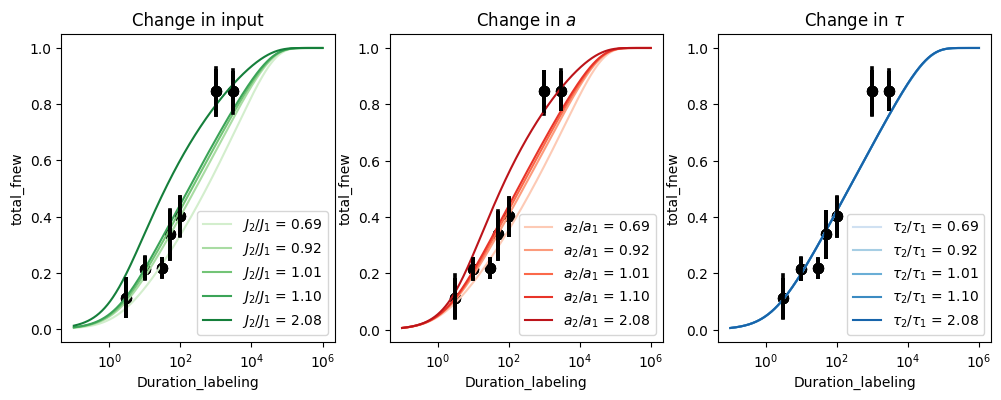

In [7]:
powerlaw_params = pd.read_csv('results/03_calibrate_models/powerlaw_model_optimization_results.csv')

a1 = powerlaw_params['tau_0'].mean()
tau1 = powerlaw_params['tau_inf'].mean()

ratios = np.percentile(J_ratio.dropna().values,[2.5, 25, 50, 75, 97.5])
ts = np.logspace(-1, 6, 1000)  # time in years

green_colors = plt.cm.Greens(np.linspace(0.2, 0.8, 5))
red_colors = plt.cm.Reds(np.linspace(0.2, 0.8, 5))
blue_colors = plt.cm.Blues(np.linspace(0.2, 0.8, 5))


int_s_labeled  = lambda t, a, tau:  a * np.exp(a / tau) * (exp1(a / tau) - exp1((a + t) / tau)  )
int_s_unlabeled = lambda t, a, tau: a * np.exp(a / tau) *  exp1((a + t) / tau) 
f_new = lambda t, J1, J2, a1, a2, tau1, tau2: J2 * int_s_labeled(t, a2, tau2) / (J2 * int_s_labeled(t, a2, tau2) + J1 * int_s_unlabeled(t, a1, tau1))

input_data = [f_new(ts, 1, 1 * j, a1, a1, tau1, tau1) for j in ratios]
a_data = [f_new(ts, 1, 1 , a1, a1 * j, tau1, tau1) for j in ratios]
tau_data = [f_new(ts, 1, 1 , a1, a1, tau1, tau1 * j) for j in ratios]

def plot_data(ax, ts, data, colors, title_label, legend_label):
    for j, d in enumerate(data):
        ax.semilogx(ts, d, color=colors[j], label=f'{legend_label} = {ratios[j]:.2f}')
        ax.set_xlabel('Time (years)')
        ax.set_ylabel('Fraction of labeled carbon')
        ax.legend(loc='lower right')
        sns.regplot(data=site_data, x="Duration_labeling", y="total_fnew",ax=ax,scatter_kws={'color':'k'},line_kws={'color':'k','lw':0},x_bins=[3,10,30,50,100,300,1000,3000],fit_reg=False,ci=95)
        ax.set_title(title_label)

fig, axs = plt.subplots(1, 3, figsize=(12, 4))    
plot_data(axs[0], ts, input_data, green_colors, 'Change in input', '$J_2$/$J_1$')
plot_data(axs[1], ts, a_data, red_colors, 'Change in $a$', '$a_2$/$a_1$')
plot_data(axs[2], ts, tau_data, blue_colors, 'Change in $\\tau$', '$\\tau_2$/$\\tau_1$')


#### Test vegetation effects

In [4]:
powerlaw_params = pd.read_csv('results/03_calibrate_models/powerlaw_model_optimization_results.csv')
powerlaw_params

,objective_value,tau_0,tau_inf,modeled_tau,modeled_14C,fm,turnover
0,8.894671e-21,1.120266,33538.025572,10.900204,0.911312,0.911312,10.900204
1,1.929256e-22,1.169804,84825.214280,12.416838,0.843955,0.843955,12.416838
2,8.980061e-22,0.676363,130859.441677,7.842942,0.827511,0.827511,7.842942
3,5.718407e-21,2.056979,93178.927742,20.866135,0.822271,0.822271,20.866135
4,1.198005e-20,1.416625,54262.107601,14.132783,0.871388,0.871388,14.132783
5,7.400436e-22,1.240448,112389.579403,13.442947,0.822875,0.822875,13.442947
6,2.077041e-21,1.866404,45476.298182,17.775912,0.877755,0.877755,17.775912
7,1.002499e-21,0.981520,93040.877199,10.681255,0.841746,0.841746,10.681255
8,1.013233e-20,2.085627,37733.009102,19.243183,0.889000,0.889000,19.243183
9,2.094452e-20,1.868017,39097.809594,17.507471,0.889000,0.889000,17.507471


In [5]:
# ts = np.logspace(-1, 6, 1000)  # time in years
ts = np.arange(0, 100000, 0.1)  # time in years
ts_veg = np.arange(0, 1000, 0.1)  # time in years
veg_age = stats.expon(scale = 450/50) # flux is NPP - 50 GtC yr-1 and stocks are 450 GtC
# veg_age = stats.expon(scale = 450/50) # flux is NPP - 50 GtC yr-1 and stocks are 450 GtC
veg_p = veg_age.pdf(ts_veg)


def make_predictions(ts, veg_p, row, label_time):
    model =PowerLawDisKin(row.loc['tau_0'], row.loc['tau_inf'])
    model_pa = model.pA(ts)
    conv_p = np.convolve(model_pa, veg_p, mode='full')[:len(ts)]
    conv_cdf = cumulative_trapezoid(conv_p, ts) / cumulative_trapezoid(conv_p, ts)[-1]
    conv_fnew = interp1d(ts[1:], conv_cdf, bounds_error=False, fill_value=0)(label_time)
    
    no_conv_cdf = cumulative_trapezoid(model_pa, ts) / cumulative_trapezoid(model_pa, ts)[-1]
    no_conv_fnew = interp1d(ts[1:], no_conv_cdf, bounds_error=False, fill_value=0)(label_time)
    # no_conv_fnew = model.cdfA(label_time)
    
    return conv_fnew, no_conv_fnew


for i, row in tqdm(powerlaw_params.iterrows()):
    conv_fnew, model_cdf = make_predictions(ts, veg_p, row, site_data.loc[i, 'Duration_labeling'])
    site_data.loc[i, 'pred_conv'] = conv_fnew
    site_data.loc[i, 'pred_no_conv'] = model_cdf

60it [02:03,  2.05s/it]


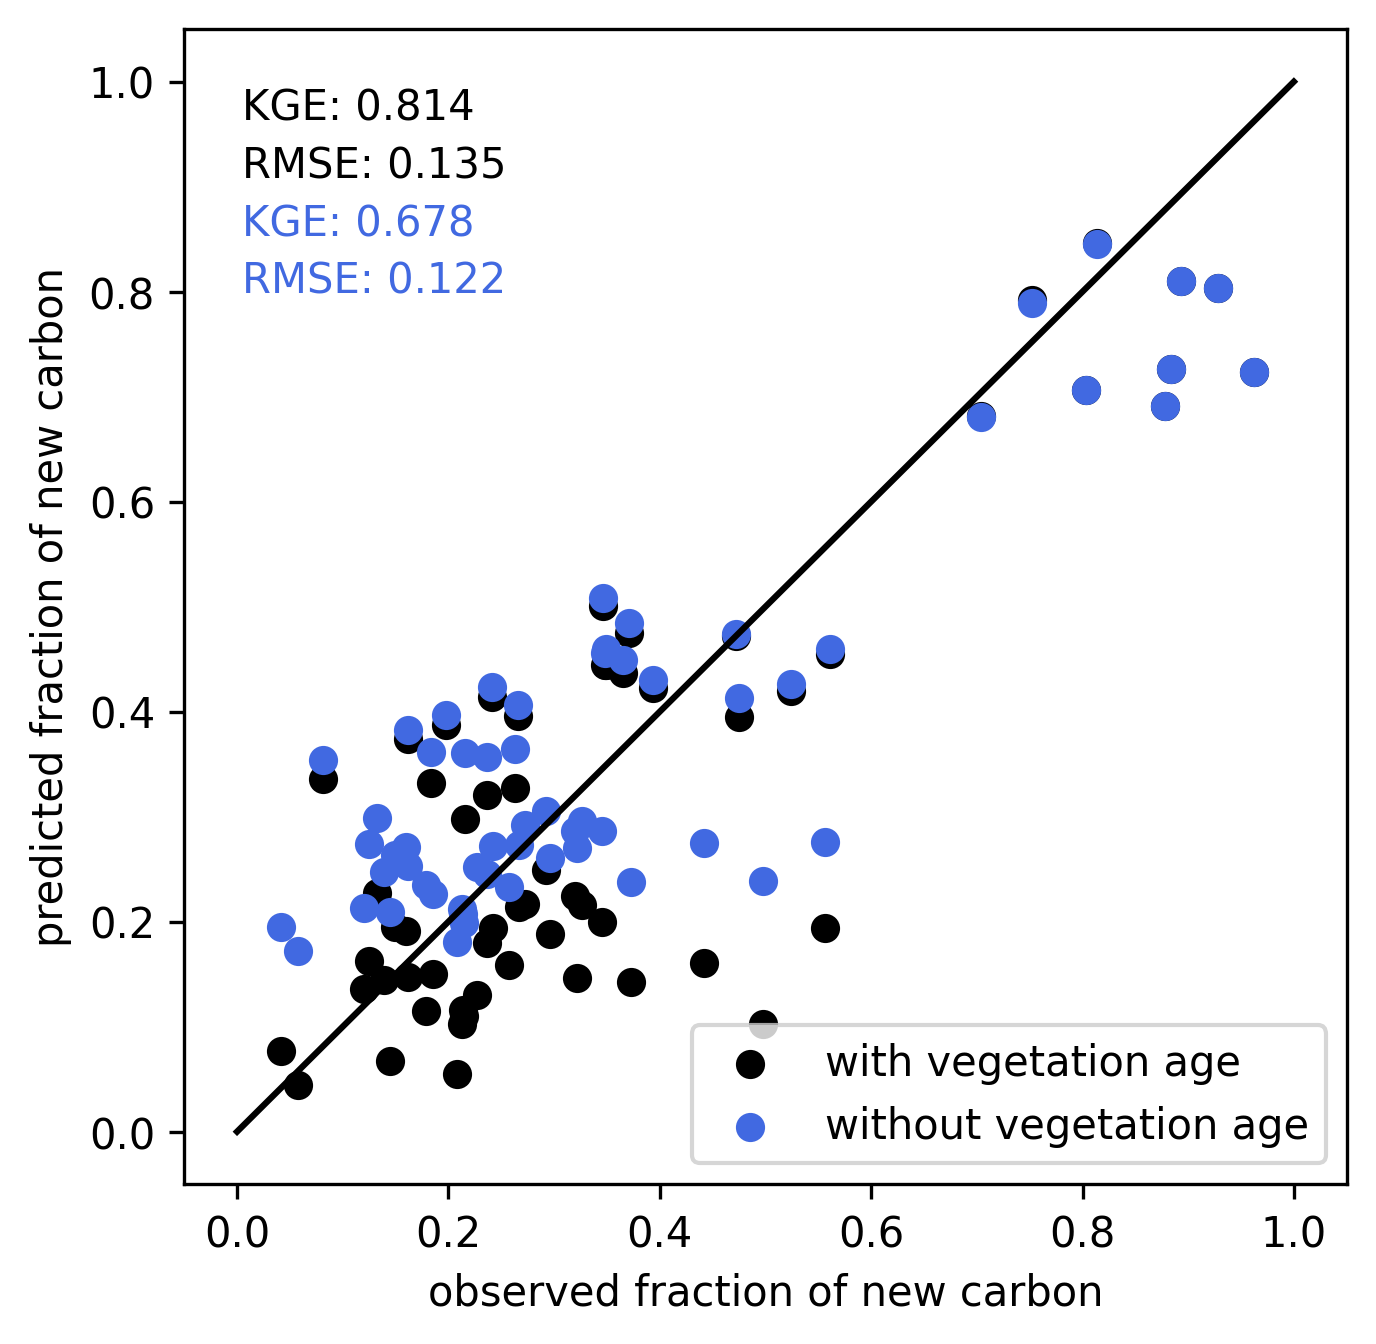

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi = 300)
ax.scatter(site_data['total_fnew'], site_data['pred_conv'], color='k')
ax.scatter(site_data['total_fnew'], site_data['pred_no_conv'], color='royalblue')


evaluator_conv = RegressionMetric(y_true=site_data['total_fnew'].values, y_pred=site_data['pred_conv'].values)
evaluator_no_conv = RegressionMetric(y_true=site_data['total_fnew'].values, y_pred=site_data['pred_no_conv'].values)

ax.text(0.05, 0.95, f'KGE: {evaluator_conv.kling_gupta_efficiency():.3f}', transform=ax.transAxes, fontsize=10, verticalalignment='top')
ax.text(0.05, 0.90, f'RMSE: {evaluator_conv.root_mean_squared_error():.3f}', transform=ax.transAxes, fontsize=10, verticalalignment='top')

ax.text(0.05, 0.85, f'KGE: {evaluator_no_conv.kling_gupta_efficiency():.3f}', transform=ax.transAxes, fontsize=10, verticalalignment='top', color='royalblue')
ax.text(0.05, 0.80, f'RMSE: {evaluator_no_conv.root_mean_squared_error():.3f}', transform=ax.transAxes, fontsize=10, verticalalignment='top', color='royalblue')
ax.set(xlabel='observed fraction of new carbon', ylabel='predicted fraction of new carbon')
plt.legend(['with vegetation age', 'without vegetation age'], loc='lower right')
ax.plot([0, 1], [0, 1], color='k', linestyle='-', label='y=x')

[Text(0.5, 0, 'observed'), Text(0, 0.5, 'predicted')]

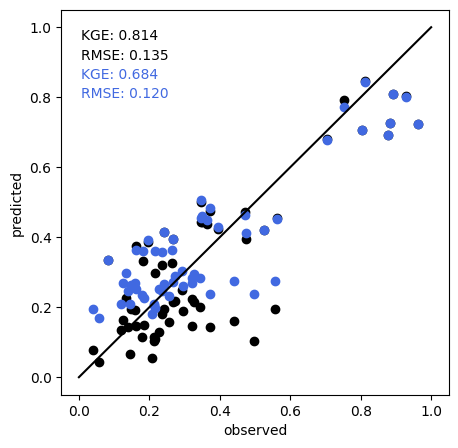

In [91]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.scatter(site_data['total_fnew'], site_data['pred_conv'], color='k')
ax.scatter(site_data['total_fnew'], site_data['pred_no_conv'], color='royalblue')
ax.plot([0, 1], [0, 1], color='k', linestyle='-', label='y=x')

evaluator_conv = RegressionMetric(y_true=site_data['total_fnew'].values, y_pred=site_data['pred_conv'].values)
evaluator_no_conv = RegressionMetric(y_true=site_data['total_fnew'].values, y_pred=site_data['pred_no_conv'].values)

ax.text(0.05, 0.95, f'KGE: {evaluator_conv.kling_gupta_efficiency():.3f}', transform=ax.transAxes, fontsize=10, verticalalignment='top')
ax.text(0.05, 0.90, f'RMSE: {evaluator_conv.root_mean_squared_error():.3f}', transform=ax.transAxes, fontsize=10, verticalalignment='top')

ax.text(0.05, 0.85, f'KGE: {evaluator_no_conv.kling_gupta_efficiency():.3f}', transform=ax.transAxes, fontsize=10, verticalalignment='top', color='royalblue')
ax.text(0.05, 0.80, f'RMSE: {evaluator_no_conv.root_mean_squared_error():.3f}', transform=ax.transAxes, fontsize=10, verticalalignment='top', color='royalblue')
ax.set(xlabel='observed', ylabel='predicted')


<Axes: xlabel='Duration_labeling', ylabel='total_fnew'>

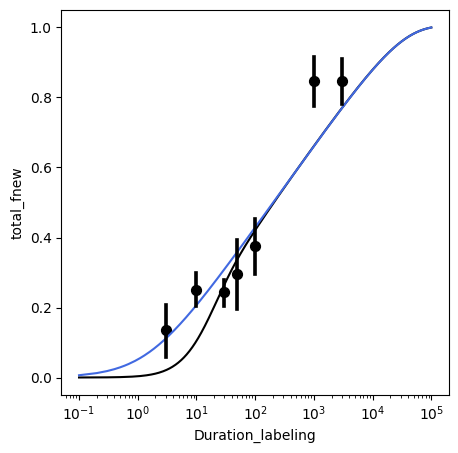

In [62]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))    
plt.semilogx(ts[1:],cumulative_trapezoid(conv_p, ts) / cumulative_trapezoid(conv_p, ts)[-1], label='Convolution', color='k')
plt.semilogx(ts[1:],cumulative_trapezoid(p, ts) / cumulative_trapezoid(p, ts)[-1], label='Convolution', color='royalblue')
sns.regplot(data=site_data, x="Duration_labeling", y="total_fnew",ax=ax,scatter_kws={'color':'k'},line_kws={'color':'k','lw':0},x_bins=[3,10,30,50,100,300,1000,3000],fit_reg=False,ci=95)